# Using a Deep Q-Network on a multi-stock portfolio

## Retrieving Data

In [4]:
!pip install fredapi

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.fundamentaldata import FundamentalData
import numpy as np
import yfinance as yf
from fredapi import Fred
import requests
api_key = "s61NxSH07BLaoJhz5GIUcvhf0JJHm5Bg"
fred_api_key = "82baef7f6db78eac5dd19dab96004b60" 

### Function to retrieve data

In [40]:



file_path = 'apple_news_data.csv'
df = pd.read_csv(file_path)


df['date'] = pd.to_datetime(df['date']).dt.date
print(df.head(20))

          date                                              title  \
0   2024-11-27  Berkshire Stock Hits Record Even as Company Re...   
1   2024-11-26                      What Is a Stock Market Index?   
2   2024-11-26  Could Investing $1,000 in Apple Make You a Mil...   
3   2024-11-26                       Dow Jones Industrial Average   
4   2024-11-26                         What Is the S&P 500 Index?   
5   2024-11-25  A Complete Guide to College Savings Accounts i...   
6   2024-11-24  How Tim Cook Cracked the Code on Working With ...   
7   2024-11-23  Warren Buffett Unloaded More Apple Shares in Q...   
8   2024-11-23  How Much Will Apple Pay Out in Dividends in 2025?   
9   2024-11-23  Could Buying Apple Stock Today Set You Up for ...   
10  2024-11-22     Huawei’s Chip Advances Threaten Apple in China   
11  2024-11-22  65% of Warren Buffett's $293 Billion Portfolio...   
12  2024-11-20  Qualcomm Plans for Life After Apple. It’s Comi...   
13  2024-11-20        Is Apple's M

Daily Average Sentiment:
            sentiment_polarity
date                          
2016-02-19            0.994000
2017-10-05            0.997000
2017-11-27            0.997000
2017-11-30            0.989000
2018-01-31            0.995000
...                        ...
2024-11-23            0.221667
2024-11-24            0.599000
2024-11-25            0.000000
2024-11-26            0.000000
2024-11-27            0.000000

[1574 rows x 1 columns]


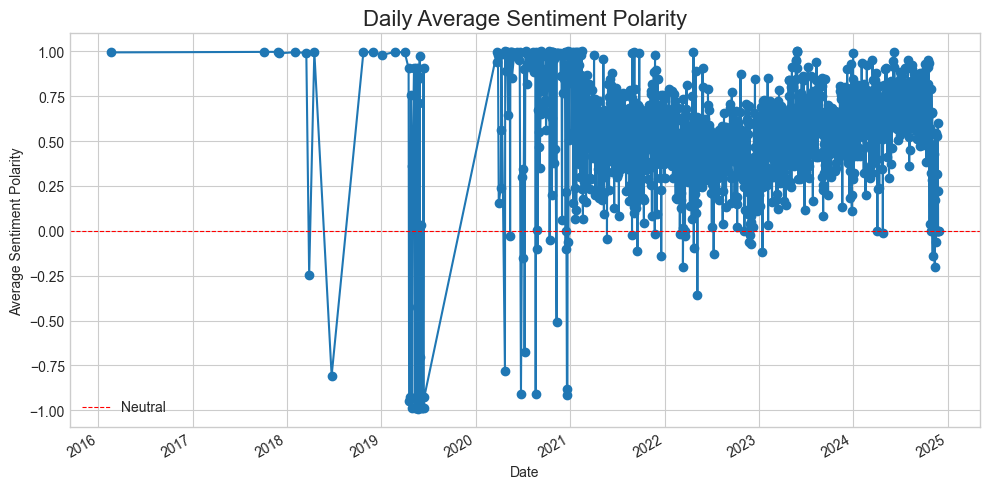

In [71]:

daily_sentiment = df.groupby('date')['sentiment_polarity'].mean().reset_index()
daily_sentiment = daily_sentiment.sort_values('date')
daily_sentiment.set_index('date', inplace=True)

daily_sentiment.index = pd.to_datetime(daily_sentiment.index)
print("Daily Average Sentiment:")
print(daily_sentiment)


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(daily_sentiment['sentiment_polarity'], 
        marker='o', linestyle='-')


ax.set_title('Daily Average Sentiment Polarity', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Average Sentiment Polarity')
ax.axhline(0, color='red', linestyle='--', linewidth=0.8, label='Neutral')
ax.legend()
fig.autofmt_xdate() 

plt.tight_layout()
plt.show()


In [42]:
def get_earnings(ticker):
    url = f"https://financialmodelingprep.com/api/v3/earnings-surprises/{ticker}?apikey={api_key}"
    response = requests.get(url)
    earnings_data = response.json()


    earnings_df = pd.DataFrame(earnings_data)
    earnings_df = earnings_df[['date', 'actualEarningResult']]
    earnings_df.rename(columns={'actualEarningResult': 'eps'}, inplace=True)
    earnings_df['date'] = pd.to_datetime(earnings_df['date'])
    earnings_df.set_index('date', inplace=True)
    return earnings_df


In [56]:
def retrieve_data(tickr):

    data = yf.download(tickr)
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    data.columns = columns
    data = data.sort_index(ascending=True)
    data['Change Percentage'] = data['Close'].pct_change() * 100
    data['Force Index'] = data['Close'].diff() * data['Volume']
    
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    raw_money_flow = typical_price * data['Volume']
    money_flow_direction = typical_price.diff()
    positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
    negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
    positive_mf = positive_flow.rolling(window=14, min_periods=0).sum()
    negative_mf = negative_flow.rolling(window=14, min_periods=0).sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        money_ratio = positive_mf / negative_mf
        data['Money Flow Index'] = 100 - (100 / (1 + money_ratio))
        data['Money Flow Index'].replace([np.inf], 100, inplace=True)

    data['Price-Volume'] = (data['Close'].pct_change() * data['Volume']).cumsum()
    data['Standard Deviation'] = data['Close'].rolling(window=20).std()
    
    earnings_df = get_earnings(tickr)
    data = data.join(earnings_df, how='left')
    data['eps'].fillna(method='ffill', inplace=True)

    data['daily_pe_ratio'] = data.apply(
        lambda row: row['Close'] / row['eps'] if row['eps'] > 0 else None,
        axis=1
    )


    
    print(data.info)
    return data

### Seperating test and train data

In [46]:
def split_data(data, start, end, test_start, test_end):
    train_data = data.loc[start : end]
    test_data = data.loc[test_start : test_end]
    return train_data, test_data

Creating close price dataframe

In [49]:
def retrieve_close(train_data, test_data):
    train_close = train_data['Close']
    test_close = test_data['Close']
    return train_close, test_close

### Normalising data

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

def PCA_transform(train_data, test_data):
    # Scaling train data
    state_features = pd.DataFrame({
        'Change Percentage': train_data['Change Percentage'],
        'Force Index': train_data['Force Index'],
        'Money Flow Index': train_data['Money Flow Index'],
        'Price-Volume': train_data['Price-Volume'],
        'Standard Deviation': train_data['Standard Deviation'],
        'daily_pe_ratio': train_data['daily_pe_ratio'],
        's-score': train_data['daily_pe_ratio']
    })
    scaler = MinMaxScaler() # Creating scaler object
    scaled_features_array = scaler.fit_transform(state_features)
    scaled_data = pd.DataFrame(scaled_features_array, columns=state_features.columns, index=state_features.index)

    # Train data PCA transform
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(scaled_data)

    # Scaling test data
    test_features = pd.DataFrame({
        'Change Percentage': test_data['Change Percentage'],
        'Force Index': test_data['Force Index'],
        'Money Flow Index': test_data['Money Flow Index'],
        'Price-Volume': test_data['Price-Volume'],
        'Standard Deviation': test_data['Standard Deviation'],
        'daily_pe_ratio': test_data['daily_pe_ratio'],
        's-score': test_data['daily_pe_ratio']
    })
    scaled_test_features_array = scaler.transform(test_features) # Using ssame scaler object as train data
    scaled_test_data = pd.DataFrame(scaled_test_features_array, columns=test_features.columns)

    # PCA transform on test data
    X_test_pca = pca.transform(scaled_test_data)

    return X_train_pca, X_test_pca



### Creating multi-stock vector

In [59]:
asset_tickers = ['AAPL', 'ABBV', 'MSFT']

In [60]:
assets_close = []
def get_vector(asset_tickers):
    assets_train_close = []
    assets_test_close = []

    assets_train_pca = []
    assets_test_pca = []
    for i in asset_tickers:
        data = retrieve_data(i)
        train_start = '2019-01-01'
        train_end = '2021-12-31'

        test_start = '2022-01-01'
        test_end = '2023-12-31'
        data_train, data_test = split_data(data, train_start, train_end, test_start, test_end)

        
        
        data_train_close, data_test_close = retrieve_close(data_train, data_test)
        assets_train_close.append(data_train_close)
        assets_test_close.append(data_test_close)



        data_train_pca, data_test_pca = PCA_transform(data_train, data_test)
        assets_train_pca.append(data_train_pca)




        scaler = MinMaxScaler(feature_range=(0, 1))



        
        assets_test_pca.append(data_test_pca)
        print(data_train)



    return assets_train_close, assets_test_close, assets_train_pca, assets_test_pca
train_close, test_close, train_pca, test_pca = get_vector(asset_tickers)
print(train_close)


[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/2695889165.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/2695889165.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

<bound method DataFrame.info of                   Open        High         Low       Close     Volume  \
Date                                                                    
1980-12-12    0.098597    0.099025    0.098597    0.098597  469033600   
1980-12-15    0.093453    0.093881    0.093453    0.093881  175884800   
1980-12-16    0.086594    0.087022    0.086594    0.087022  105728000   
1980-12-17    0.088737    0.089165    0.088737    0.088737   86441600   
1980-12-18    0.091310    0.091738    0.091310    0.091310   73449600   
...                ...         ...         ...         ...        ...   
2025-07-23  214.149994  215.149994  212.410004  215.000000   46989300   
2025-07-24  213.759995  215.690002  213.529999  213.899994   46022600   
2025-07-25  213.880005  215.240005  213.399994  214.699997   40268800   
2025-07-28  214.050003  214.850006  213.059998  214.029999   37858000   
2025-07-29  211.270004  214.809998  210.820007  214.179993   49943600   

            Change

[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/2695889165.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/2695889165.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

<bound method DataFrame.info of                   Open        High         Low       Close    Volume  \
Date                                                                   
2013-01-02   21.049097   21.216916   20.437762   20.929227  13767900   
2013-01-03   20.875301   20.977189   20.473737   20.977189  16739300   
2013-01-04   20.611586   20.911260   20.527677   20.749435  21372100   
2013-01-07   20.653538   21.246893   20.467741   20.467741  17897100   
2013-01-08   20.204031   20.761425   19.994260   20.551654  17863300   
...                ...         ...         ...         ...       ...   
2025-07-23  190.550003  190.800003  186.770004  187.050003   4344500   
2025-07-24  190.830002  192.240005  189.990005  190.759995   3462700   
2025-07-25  190.279999  191.399994  188.529999  191.399994   3786800   
2025-07-28  188.520004  191.210007  187.639999  191.210007   3776900   
2025-07-29  191.220001  192.490005  187.860001  189.149994   6485400   

            Change Percentage  

[*********************100%***********************]  1 of 1 completed
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/2695889165.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Money Flow Index'].replace([np.inf], 100, inplace=True)


<bound method DataFrame.info of                   Open        High         Low       Close      Volume  \
Date                                                                     
1986-03-13    0.059598    0.062259    0.054277    0.054277  1031788800   
1986-03-14    0.061726    0.062791    0.059598    0.059598   308160000   
1986-03-17    0.062791    0.063323    0.061726    0.061726   133171200   
1986-03-18    0.061194    0.063323    0.060662    0.062791    67766400   
1986-03-19    0.060130    0.061726    0.059598    0.061194    47894400   
...                ...         ...         ...         ...         ...   
2025-07-23  505.869995  506.790009  500.700012  506.750000    16396600   
2025-07-24  510.880005  513.669983  507.299988  508.769989    16107000   
2025-07-25  513.710022  518.289978  510.359985  512.469971    19125700   
2025-07-28  512.500000  515.000000  510.119995  514.080017    14308000   
2025-07-29  512.570007  517.619995  511.559998  515.530029    16444700   

     

/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/2695889165.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['eps'].fillna(method='ffill', inplace=True)
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/2695889165.py:27: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['eps'].fillna(method='ffill', inplace=True)


In [61]:
def retrieve_risk_free():
    fred = Fred(api_key=fred_api_key)
    risk_free_rate = fred.get_series('DTB3')
    risk_free_rate = risk_free_rate.dropna()
    
    risk_free_train, risk_free_test = split_data(risk_free_rate, '2019-01-01', '2021-12-31', '2022-01-01', '2023-12-31')
    
    risk_free_aligned_train = risk_free_train.reindex(train_close[0].index)
    risk_free_aligned_train.ffill(inplace=True)

    risk_free_aligned_test = risk_free_test.reindex(test_close[0].index)
    risk_free_aligned_test.ffill(inplace=True)
    
    return risk_free_aligned_train, risk_free_aligned_test

In [106]:
risk_free_train, risk_free_test = retrieve_risk_free()
print(risk_free_train)

Date
2019-01-02    2.37
2019-01-03    2.36
2019-01-04    2.37
2019-01-07    2.41
2019-01-08    2.41
              ... 
2021-12-27    0.06
2021-12-28    0.06
2021-12-29    0.05
2021-12-30    0.05
2021-12-31    0.06
Length: 757, dtype: float64


In [107]:
def sentiment():
    
    daily_sentiment1 = daily_sentiment.dropna()
    sentiment_train, sentiment_test = split_data(daily_sentiment, '2019-01-01', '2021-12-31', '2022-01-01', '2023-12-31')
    
    sentiment_aligned_train = sentiment_train.reindex(train_close[0].index)
    sentiment_aligned_train.ffill(inplace=True)
    sentiment_aligned_train.fillna(0, inplace=True)

    sentiment_aligned_test = sentiment_test.reindex(test_close[0].index)
    sentiment_aligned_test.ffill(inplace=True)
    
    return sentiment_aligned_train, sentiment_aligned_test

In [108]:
sentiment_train, sentiment_test = sentiment()
print(sentiment_train)

            sentiment_polarity
Date                          
2019-01-02            0.000000
2019-01-03            0.979500
2019-01-04            0.979500
2019-01-07            0.979500
2019-01-08            0.979500
...                        ...
2021-12-27            0.672609
2021-12-28            0.635694
2021-12-29            0.374281
2021-12-30            0.425929
2021-12-31            0.458154

[757 rows x 1 columns]


## Creating Deep Q Network

### Setting up environment

In [75]:
import itertools
import math
ATOMIC_HOLDINGS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
STOCKS = ['STOCK_A', 'STOCK_B', 'stock c']

all_possible_combos = itertools.product(ATOMIC_HOLDINGS, repeat=len(STOCKS))

ACTIONS = [
    list(combo) for combo in all_possible_combos if sum(combo) <= 1.0
]
print(len(ACTIONS))

286


In [119]:
class environment:

    def __init__(self, price_data, PCA_data, risk_free_data, sentiment):
        self.data = price_data
        self.assets_pca = PCA_data
        self.cash_balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = [0,0,0] # Number of shares owned for each stock in portfolio
        self.trend = None
        self.balance_history = []
        self.price = None
        self.rewards = []
        self.total_reward = 0
        self.total = 100
        self.trades = []
        self.action_history = []
        self.weight_vector = [0,0,0]
        self.return_history = []
        self.risk_free_data = risk_free_data
        self.sentiment = sentiment


    
    
        

    def step(self, action):

        stocks = self.data
        stock1 = stocks[0]
        trade = [] 
        if self.index <= len(stock1):
            data = self.data
            index = self.index
            old_net_worth = self.get_net_worth()
            total = self.get_net_worth()
            cash_balance = self.cash_balance
            trade.append(total)
            trade.append(action)
            cash_weight = 1
            for i in action:
                cash_weight -= i
                
            for i in range(len(action)):
                stock_data = self.data[i]
                

                current_weight = (self.num_shares[i] * stock_data.iloc[self.index]) / total
                
                trade.append(current_weight)
                trade.append(action)
                self.action_history.append(action[i])
                
                
                

                # Checking if action should buy or sell stock
                if action[i] > current_weight:

                    # Calculating cash amount to buy
                    to_buy = (action[i] - current_weight) * total

                    
                    

                    # Calculating new number of shares
                    new_shares = to_buy / stock_data.iloc[self.index]

                    # Adding new shares to total shares
                    self.num_shares[i] += new_shares

                    

                
                elif action[i] < current_weight:
                    to_sell = (current_weight - action[i]) * total
                    shares_to_sell = to_sell / stock_data.iloc[self.index]
                    new_num_shares = self.num_shares[i] - shares_to_sell
                    self.num_shares[i] = new_num_shares
                    
            
            self.cash_balance = total * cash_weight
            self.balance_history.append(old_net_worth)



            
            annual_rate = self.risk_free_data[self.index] / 100
            # Daily risk-free rate
            daily_rate = annual_rate / 365
            self.cash_balance = self.cash_balance * (1+ daily_rate)
            trade.append(self.num_shares)
            trade.append(self.cash_balance)
            

            if self.index < (len(stock1)-1):
                self.index += 1
                volatility_window = 7 
    
        
                if self.index > volatility_window:
        
                    historical_data_window = [
                        asset.iloc[self.index - volatility_window : self.index] for asset in self.data
                    ]
        
        
                    asset_returns_window = [data.pct_change().dropna() for data in historical_data_window]
        
                    asset_returns_matrix = np.array(asset_returns_window).T
        
       
                    projected_portfolio_returns = np.dot(asset_returns_matrix, action)
        
        
                    forward_looking_volatility = np.std(projected_portfolio_returns)
                else:
                    forward_looking_volatility = 0.0

                # Defining how much the model should focus on reducing risk
                risk_aversion_gamma = 0 
    
                
                
                new_net_worth = self.get_net_worth()
                
                # The reward is the change in value
                portfolio_return = (new_net_worth - old_net_worth) / old_net_worth
                self.return_history.append(portfolio_return)

                reward = portfolio_return - (risk_aversion_gamma * forward_looking_volatility)
                
                self.trades.append(trade)
                self.total_reward += reward
                self.rewards.append(self.total_reward)
                self.weight_vector = action
        
            else:
                self.index += 1
                reward = 0
            return (reward, False)
        else:
            return (0, True)
        
    def reset(self):
        self.cash_balance = 100
        self.holding = 0
        self.index = 0
        self.buy_price = None
        self.sell_price = None
        self.num_shares = [0,0,0]
        self.trend = None
        self.balance_history = []
        self.trades = []
        self.weight_vector = [0,0,0]
        self.return_history = []
    
    def get_net_worth(self):
        data = self.data
        total = 0
        num_shares = self.num_shares
        for i in range(len(num_shares)):
            price_data = data[i]
            total += num_shares[i] * price_data.iloc[self.index]
        total += self.cash_balance
        return total
        
    def get_state(self):
        state = []
        
        for i in range(0, len(self.assets_pca)):
            stock_pca = self.assets_pca[i]
            
           
            

            current_pca = stock_pca[self.index]
            
          
            for i in current_pca:
                state.append(i)
        day = self.sentiment.iloc[self.index]
        state.append(day['sentiment_polarity'])
        state.append(self.risk_free_data[self.index])
        return state


### Training the model

In [281]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import itertools
import math

# Create the Stock Environment
def train_model(env):
    
    
    # Neural network model for approximating Q-values
    class DQN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(DQN, self).__init__()
            self.fc1 = nn.Linear(input_dim, 256)
            self.fc2 = nn.Linear(256, 256)
            self.fc3 = nn.Linear(256, 256)
            self.fc4 = nn.Linear(256, output_dim)
        
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            return self.fc4(x)
    
    # Hyperparameters
    learning_rate = 0.0001
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.9995
    batch_size = 64
    target_update_freq = 1000
    memory_size = 100000
    episodes = 2000
    
    ATOMIC_HOLDINGS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    STOCKS = ['STOCK_A', 'STOCK_B', 'stock c']
    
    all_possible_combos = itertools.product(ATOMIC_HOLDINGS, repeat=len(STOCKS))
    
    ACTIONS = [
        list(combo) for combo in all_possible_combos if sum(combo) <= 1.0
    ]
    
    # Initialize Q-networks
    input_dim = 16
    output_dim = 286
    policy_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = deque(maxlen=memory_size)
    
    # Function to choose action using epsilon-greedy policy
    def select_action(state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, len(ACTIONS) - 1)  # Explore
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state)
            return torch.argmax(q_values).item()
            
    
    # Function to optimise the model using experience replay
    def optimize_model():
        if len(memory) < batch_size:
            return
        
        batch = random.sample(memory, batch_size)
    
        state_batch, action_batch, reward_batch, next_state_batch = zip(*batch)
        state_batch = torch.FloatTensor(np.array(state_batch, dtype=np.float32))
    
        state_batch = torch.FloatTensor(state_batch)
        
     
        action_batch = torch.LongTensor(action_batch).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch)
        next_state_batch = torch.FloatTensor(next_state_batch)
        
    
        # Compute Q-values for current states
    
        # Now the gather operation will work
        q_values = policy_net(state_batch).gather(1, action_batch).squeeze()
    
        # Compute target Q-values using the target network
        with torch.no_grad():
            max_next_q_values = target_net(next_state_batch).max(1)[0]
            target_q_values = reward_batch + gamma * max_next_q_values
    
        loss = nn.MSELoss()(q_values, target_q_values)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Main training loop
    steps_done = 0
    rewards = []
    
    for episode in range(episodes):
        episode_reward = 0
        state = env.get_state()
        done = False
        i = 0
        
        for i in range(len(train_close[i])-1):
            # Select action
            action_index = select_action(state, epsilon)
           
            action = ACTIONS[action_index]
            reward, done = env.step(action)
            episode_reward += reward
            
            next_state = env.get_state()
            # Store transition in memory
            memory.append((state, action_index, reward, next_state))
            
            # Update state
            state = next_state
    
            # Optimise
            optimize_model()
            steps_done += 1
            
    
            # Update target network periodically
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
    
    
        # Decay epsilon
        rewards.append(episode_reward)
        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        env.reset()
 
    return policy_net

## Testing

In [276]:
def test(env, policy_net):
    
    # Reset the environment
    env.reset()  

    step = 0
    done = False
    action_history = []
    sum = 0
    stock1 = test_close[0]
    
    while env.index < (len(stock1)):
   
        state = env.get_state()
       
     
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action_index = torch.argmax(q_values).item()
            
            action = ACTIONS[action_index]
       

        env.step(action)
        sum += 1
        
     

        if done:
            break
   

### Training model multiple times

In [277]:
returns = []
sharpes = []
histories = []

In [280]:
for i in range(10):
    env = environment(train_close, train_pca, risk_free_train, sentiment_train)
    policy_net = train_model(env)
    test_env = environment(test_close, test_pca, risk_free_test, sentiment_test)
    test(test_env, policy_net)
    return_iteration = ((test_env.balance_history[-1] - test_env.balance_history[0]) / test_env.balance_history[0])
    returns.append(return_iteration)
    daily_std = np.std(test_env.return_history)
    annual_std = daily_std * np.sqrt(252)
    sharpe_ratio = return_iteration / annual_std
    sharpes.append(sharpe_ratio)
    histories.append(test_env.balance_history) 
      

/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/3797160304.py:187: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state.append(self.risk_free_data[self.index])
/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/3797160304.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annual_rate = self.risk_free_data[self.index] / 100


### Calculating average returns

In [265]:
total = 0
for i in returns:
    total += i
avg = total/len(returns)
print(avg)
print(returns)


0.35376587303906604
[0.43410418560515096, 0.2789745197322506, 0.33217359064352, 0.5808312197945327, 0.38694943354987715, 0.09833413894845336, 0.567442619366619, 0.0228490189940338, 0.34457113003806056, 0.4914288737181616]


### Calculating average sharpe ratio

In [266]:
array = np.array(histories)
np.savetxt("Sentiment-output.txt", array, delimiter=",")

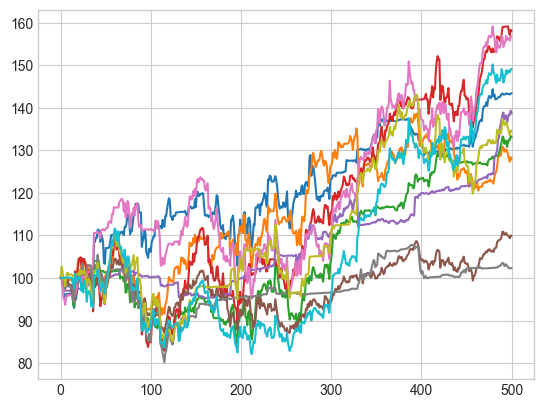

In [267]:
for i in histories:
    plt.plot(i)
plt.show()

In [268]:
total = 0
for i in sharpes:
    total += i
avg = total/len(sharpes)
print(avg)
print(sharpes)

1.774391591419753
[2.1734575477202966, 1.2623191782217746, 1.6044435848987304, 2.2853656238503692, 3.6972556511074885, 0.5886498188705723, 2.282991652827444, 0.13256384967594892, 1.521472547879612, 2.195396459145295]


### Plotting model performace against underlying stock price

In [269]:
df1 = pd.DataFrame(test_close[0])
df1.columns = ['Close']
df1['Model_Balance'] = test_env.balance_history
print(df1)

                 Close  Model_Balance
Date                                 
2022-01-03  174.542917     100.000000
2022-01-04  179.254159      99.994314
2022-01-05  176.290033      99.970128
2022-01-06  169.507783     100.074020
2022-01-07  169.694211     100.074294
...                ...            ...
2023-12-22  193.761051     148.355695
2023-12-26  192.202487     148.779197
2023-12-27  191.090629     148.313598
2023-12-28  192.728625     148.915799
2023-12-29  192.490361     149.142887

[501 rows x 2 columns]


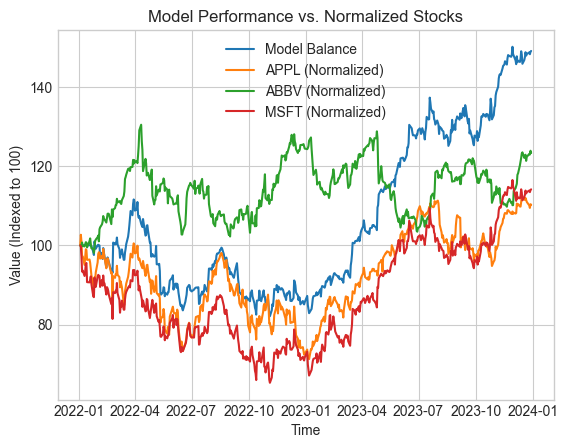

In [270]:
appl_scaled = (test_close[0] / test_close[0].iloc[0]) * 100
abbv_scaled = (test_close[1] / test_close[1].iloc[0]) * 100
msft_scaled = (test_close[2] / test_close[2].iloc[0]) * 100


# Plot the data
plt.plot(df1['Model_Balance'], label="Model Balance")
plt.plot(appl_scaled, label="APPL (Normalized)")
plt.plot(abbv_scaled, label="ABBV (Normalized)")
plt.plot(msft_scaled, label="MSFT (Normalized)")


plt.title("Model Performance vs. Normalized Stocks")
plt.xlabel("Time")
plt.ylabel("Value (Indexed to 100)")
plt.legend()
plt.grid(True)
plt.savefig("model_performance_misc.png")
plt.show()

In [251]:
equal_weight_df = pd.DataFrame({
    'Stock0': test_close[0],
    'Stock1': test_close[1],
    'Stock2': test_close[2]
})


daily_asset_returns = equal_weight_df.pct_change().dropna()


weights = np.array([1/3, 1/3, 1/3])


equal_weight_returns = np.dot(daily_asset_returns, weights)
total_returns = (equal_weight_df.iloc[-1] / equal_weight_df.iloc[0]) - 1
equal_portfolio_return = total_returns.mean()

In [252]:
baseline_day_std = np.std(equal_weight_returns)
baseline_year_std = baseline_day_std * np.sqrt(252)
baseline_sharpe = totalr / baseline_year_std
print(equal_portfolio_return)
print(baseline_sharpe)

0.15940790206507308
1.1205485094942063


## Importing non sentiment data to compare

In [253]:
import numpy as np
import matplotlib as plt
file_name = "output.txt"

# Load the data from the text file back into a NumPy array
# Ensure the delimiter matches the one you used to save the file (e.g., ",")
loaded_array = np.loadtxt(file_name, delimiter=",")

In [254]:
print(loaded_array)

[[100.          99.94684565  99.72752108 ... 114.8817284  115.16173677
  115.10808258]
 [100.          99.96464596  99.81847657 ... 121.31105047 121.38126016
  121.41734784]
 [100.         102.69922361 101.00094787 ...  96.59097722  97.02520401
   97.18806706]
 ...
 [100.          99.9883797   99.93979111 ... 157.57333533 157.84924573
  157.77570331]
 [100.         101.29720478  99.62085966 ...  98.02505838  98.42307199
   98.57317618]
 [100.         100.21534595  99.41499205 ... 125.84577206 126.06959552
  126.0669558 ]]


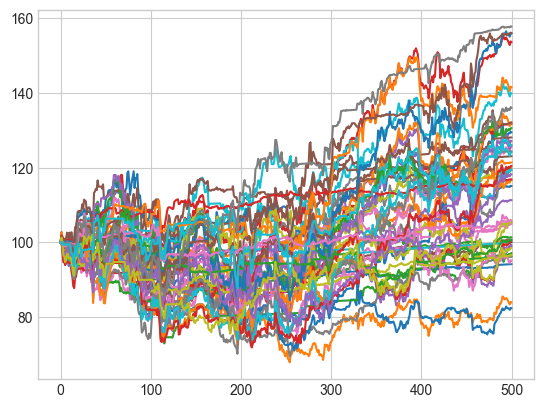

In [255]:
import matplotlib.pyplot as plt
for i in loaded_array:
    plt.plot(i)
plt.show()

In [225]:
non_sent_returns = []
for i in loaded_array:
    non_sent_returns.append((i[-1] - i[0]) /i[0])
print(non_sent_returns)

[0.15108082581018764, 0.2141734783664363, -0.028119329428125325, 0.5360213224249344, -0.009404732039815115, 0.007623759996876203, 0.05461484877541295, 0.193061356569183, 0.057738929441807446, 0.3989205907641252, 0.29437878180950716, -0.16025896380915328, 0.013744221889132149, 0.3169025190740743, 0.271080344112567, 0.2812304126699289, 0.2554479496865028, 0.24404079805587117, 0.20060244696073568, 0.00033116967719536204, -0.057914551738272306, 0.31972420585388134, -0.03762691025860278, 0.001541352314092137, 0.25994307225425756, 0.23086398374845443, 0.04986047819803858, -0.037468801103530326, 0.054208638765908715, 0.19599991115018042, -0.1759132734776469, 0.16704021417857448, 0.30645482064388146, 0.16889937348661987, 0.1132683638951218, 0.32175912230512466, -0.04828814817921085, 0.3600543895507775, -0.034456095756071364, 0.2416989227330393, 0.5599346870838309, 0.41555991503755707, 0.0060132884890592205, 0.20505088261254642, 0.18227563958554185, 0.5604575341392354, 0.05859279744094863, 0.57

In [226]:
non_sent_sharpes = [0.703842002453317, 1.1101613459385204, -0.1410023658997493, 2.6578081291018774, -0.04230758954405956, 0.048513011439719325, 0.26658572476753556, 1.11000590588594, 0.26957234721856527, 1.81341914984921, 1.6887197811621038, -0.6791040778882216, 0.12002233813089369, 1.8791213934114581, 1.1749756627370067, 2.183183778115846, 1.3218087551694606, 1.0561777036504563, 1.3086107879102304, 0.006104539842455669, -0.7267072020329722, 1.7060871289165875, -0.27878638181784043, 0.007968930605558392, 1.183859183313235, 1.4743277710630054, 0.26013181427284726, -0.20205694368897315, 0.2892178962635964, 1.096415059803866, -0.7456972649073467, 0.689189686469228, 1.182911880476805, 2.0690184024216527, 0.5331418914300716, 1.5349714431400603, -0.1818930053808707, 1.440313024224447, -0.33072962391400307, 0.9238958038215224, 2.432795530054021, 2.309484994320537, 0.04826146694504776, 1.0256146526689196, 0.7602962379150728, 2.4394290110662324, 0.8458902653914702, 2.8552537590628297, -0.07455163377500891, 1.3106936237766664]

/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/3940863275.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(returns_to_plot, labels=['Non-Sentiment', 'Sentiment'])


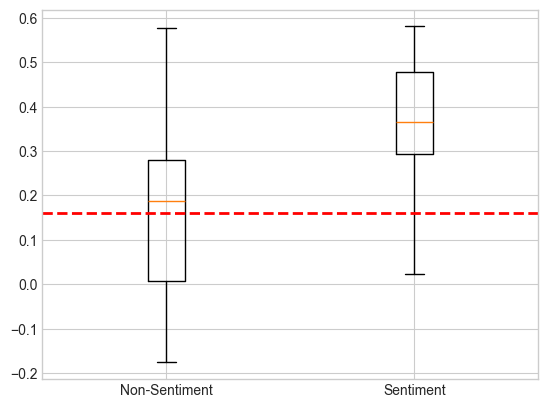

<Figure size 640x480 with 0 Axes>

In [271]:
returns_to_plot = [non_sent_returns, returns]
plt.boxplot(returns_to_plot, labels=['Non-Sentiment', 'Sentiment'])

plt.axhline(y=equal_portfolio_return, color='red', linestyle='--', linewidth=2)
plt.show()
plt.savefig("returns_box_sent.png")

/var/folders/jk/qtzrzz695z1gpn8f1qgj7n2m0000gn/T/ipykernel_1730/2839461439.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sharpes_to_plot, labels=['Non-Sentiment', 'Sentiment'])


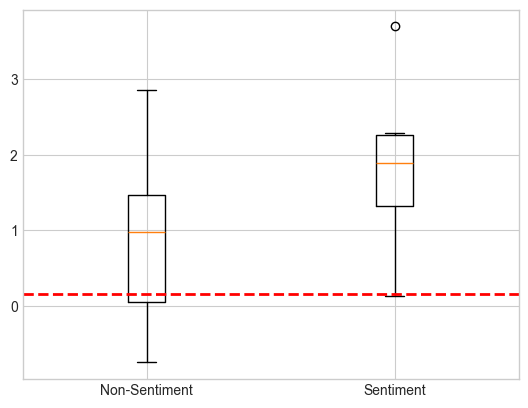

<Figure size 640x480 with 0 Axes>

In [272]:
sharpes_to_plot = [non_sent_sharpes, sharpes]
plt.boxplot(sharpes_to_plot, labels=['Non-Sentiment', 'Sentiment'])

plt.axhline(y=equal_portfolio_return, color='red', linestyle='--', linewidth=2)
plt.show()
plt.savefig("sharpes_box_sent.png")

## New dataset

In [33]:

import tickertick as tt
import tickertick.query as query

feed = tt.get_feed(
    query = query.BroadTicker('AAPL'),
    no=500
     
) # SEC filings from Apple Inc.


In [34]:
import pandas as pd

# feed = tt.get_feed(...) # Your list of Story objects

# Manually create a list of dictionaries by accessing each attribute
stories_list = [
    {
        'id': s.id,
        'url': s.url,
        'site': s.site,
        'time': s.time,
        'favicon_url': s.favicon_url,
        'tags': s.tags,
        'description': s.description
    } 
    for s in feed
]

# Create the DataFrame from the new list of dictionaries
df = pd.DataFrame(stories_list)

print(df.head())

                     id                                                url  \
0  -5533864941913229876  https://forums.macrumors.com/threads/apple-pro...   
1  -8029687693377922619  https://forums.macrumors.com/threads/how-do-i-...   
2    235164946681461691  https://www.forbes.com/sites/davidphelan/2025/...   
3    935646877124182070  https://www.macworld.com/article/2862474/macos...   
4   3821986572658248446  https://9to5toys.com/2025/07/30/deal-apple-32g...   

            site                      time  \
0  macrumors.com 2025-07-30 10:38:24+00:00   
1  macrumors.com 2025-07-30 10:37:12+00:00   
2     forbes.com 2025-07-30 10:32:31+00:00   
3   macworld.com 2025-07-30 10:30:00+00:00   
4   9to5toys.com 2025-07-30 10:17:21+00:00   

                                         favicon_url    tags  \
0  https://static.tickertick.com/website_icons/ma...  [aapl]   
1  https://static.tickertick.com/website_icons/ma...  [aapl]   
2  https://static.tickertick.com/website_icons/fo...  [aapl]  

In [22]:
import pandas as pd
import requests

url = "https://api.tickertick.com/feed?q=z:aapl&n=300"

# Define a header that mimics a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
}

# Make the request using the headers
response = requests.get(url, headers=headers)
response.raise_for_status()  # This will raise an error if the request failed

# Load the JSON data from the successful response
data = response.json()
data_stories = data['stories']
df = pd.DataFrame(data_stories)
last = data['last_id']
print(last)

print(df.tail)


-308439342978177630
<bound method NDFrame.tail of                        id                                              title  \
0    -2173775591354815711  India’s Mobile Shipments Saw 8 Percent Growth ...   
1     3397647163953596451  Apple just showed what 20 iPhones can do on a ...   
2     6505443793077586504  PSA: New ‘choicejacking’ attacks can steal you...   
3     8731171174195449469  Apple's Android and iOS-compatible Beats Solo ...   
4    -6118099002928055649  PayPal's AI-Powered Renaissance: a compelling ...   
..                    ...                                                ...   
145   5013014027701485702                 5 annoying Apple TV quirks, solved   
146   4351004625586311921  JPMorgan Chase in Talks to Take Over Apple’s C...   
147   5177153210818202095      Apple trebles presence at Touchwood, Solihull   
148   8265959145516135252  JPMorgan Chase and Apple Near Deal on Credit C...   
149   -308439342978177630  Buy a 2.4-inch Macintosh Plus before Apple 

In [13]:
print(data)

[{'id': '-2173775591354815711', 'title': 'India’s Mobile Shipments Saw 8 Percent Growth In Q2 2025, iPhone 16 Lead the Charts: Report', 'url': 'https://www.gadgets360.com/mobiles/news/india-mobile-shipments-growth-8-percent-yoy-second-quarter-2025-iphone-16-most-shipped-8982208#rss-gadgets-news', 'site': 'gadgets360.com', 'time': 1753869170000, 'favicon_url': 'https://static.tickertick.com/website_icons/gadgets360.com.ico', 'tags': ['aapl'], 'description': 'In the second quarter of 2025, India’s smartphone market grew 8 percent from the same quarter last year. This comes after the country saw “muted” growth in the first quarter, according to a market research firm. This growth is being attributed to the 33 percent year-on-year (YoY) growth in new mobile launches, aggressive marketing, and steady performance during ...', 'tickers': ['aapl']}, {'id': '3397647163953596451', 'title': 'Apple just showed what 20 iPhones can do on a movie set', 'url': 'https://www.phonearena.com/news/apple-ju

In [20]:
df['date'] = pd.to_datetime(df['time'], unit='ms')

In [21]:
print(df)

                       id                                              title  \
0    -2173775591354815711  India’s Mobile Shipments Saw 8 Percent Growth ...   
1     3397647163953596451  Apple just showed what 20 iPhones can do on a ...   
2     6505443793077586504  PSA: New ‘choicejacking’ attacks can steal you...   
3     8731171174195449469  Apple's Android and iOS-compatible Beats Solo ...   
4    -6118099002928055649  PayPal's AI-Powered Renaissance: a compelling ...   
..                    ...                                                ...   
145   5013014027701485702                 5 annoying Apple TV quirks, solved   
146   4351004625586311921  JPMorgan Chase in Talks to Take Over Apple’s C...   
147   5177153210818202095      Apple trebles presence at Touchwood, Solihull   
148   8265959145516135252  JPMorgan Chase and Apple Near Deal on Credit C...   
149   -308439342978177630  Buy a 2.4-inch Macintosh Plus before Apple sto...   

                                       

In [35]:
import pandas as pd
import requests

# Replace with the actual URL you are trying to access
url = "https://tickertick.com/datasets/TickerTick-stock-news-dataset.2023-11-23.json.bz2"

# The headers help mimic a browser request
headers = {
    'Accept-Encoding': 'gzip, deflate, br',
    'User-Agent': 'Mozilla/5.0'
}

# The requests library will automatically decompress the gzipped content
response = requests.get(url, headers=headers)
response.raise_for_status()  # This will raise an error if the request failed

# Load the decompressed JSON data directly into a pandas DataFrame
data = response.json()
df = pd.DataFrame(data)

print(df.head())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)